# Lendo dados experimentais


   vazao    h1    h2
0    0.0 -0.47 -0.06
1    0.0 -0.57 -0.06
2    0.0 -0.57 -0.16
3    0.0 -0.07 -0.16
4    0.0 -0.47 -0.06


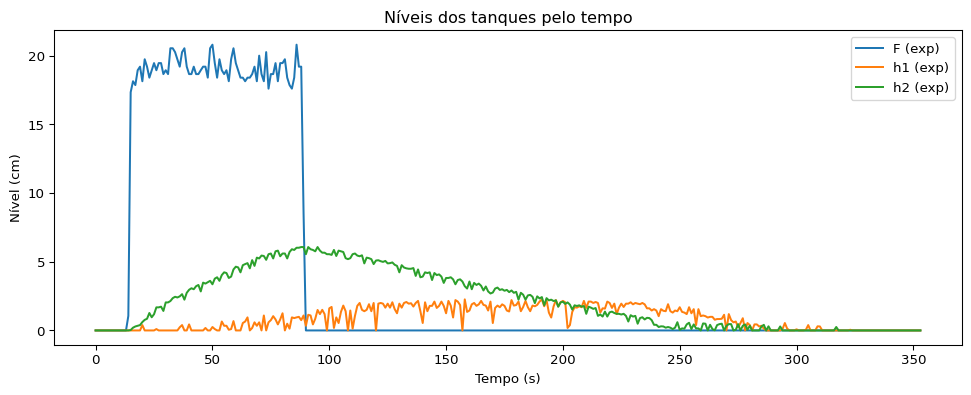

In [2]:
import numpy as np
import pandas as pd

from plot import plot_tanks

exp_data = pd.read_csv("../dados.csv")

F_exp = exp_data["vazao"].to_numpy() * 2
h1_exp = np.clip(exp_data["h1"].to_numpy(), 0.0, None)
h2_exp = np.clip(exp_data["h2"].to_numpy(), 0.0, None)
t = np.arange(len(F_exp))

print(exp_data.head())

plot_tanks(t, [F_exp, h1_exp, h2_exp], ["F (exp)", "h1 (exp)", "h2 (exp)"])



# Definindo o Sistema 



In [3]:
import numpy as np
from scipy.integrate import solve_ivp

from typings import Bounds


def F(t: float | int):
    return F_exp[int(t)]


def edo(t, Y, cv1, cv2):
    # Constantes
    a2 = 10 * 15  # cm^2
    a1 = np.pi * (11 / 2) ** 2  # cm^2
    # a2 = 160.0
    # a1 = 95.03

    # Dependent variables
    h2, h1 = Y[0], Y[1]

    # Tanks limits
    h2 = np.where(h2 < 0.0, 0.0, h2)
    h1 = np.where(h1 < 0.0, 0.0, h1)

    # Equations
    dh2dt = (F(t) / a2) - ((cv2 * np.sqrt(h2)) / a2)
    dh1dt = ((cv2 * np.sqrt(h2)) / a1) - ((cv1 * np.sqrt(h1)) / a1)
    return [dh2dt, dh1dt]


def simulate(c1, c2):
    sol = solve_ivp(
        edo,
        [t[0], t[-1]],
        [h1_exp[0], h2_exp[0]],
        t_eval=t,
        method="RK45",
        args=(c1, c2),
    )
    return sol.y


bounds: Bounds = [(0, -8), (0, 8)]  # Limites para Cv1 e Cv2


# Definindo Função Objetivo 



In [4]:


def loss(C):
    c1, c2 = C
    h2_sim, h1_sim = simulate(c1, c2)
    total_loss = np.mean(np.square(h1_exp - h1_sim)) + np.mean(
        np.square(h2_exp - h2_sim)
    )

    # print(f"c1: {c1}, c2: {c2}, loss: {total_loss}")
    return total_loss


In [5]:
from pyswarm import pso


lb = [-10, -10]  # Limite inferior
ub = [10, 10]    # Limite superior

#lb = [bounds[0][0], bounds[0][1]]  # Limite inferior
#ub = [bounds[1][0], bounds[1][1]]    # Limite superior

xopt, fopt = pso(loss, lb, ub)
print("Solução ótima:", xopt)
print("Valor da função:", fopt)

Stopping search: Swarm best objective change less than 1e-08
Solução ótima: [4.58442456 3.04090619]
Valor da função: 0.3391510994184169


 The best solution found:                                                                           
 [4.96100976 3.35927933]

 Objective function:
 0.3805171993414021


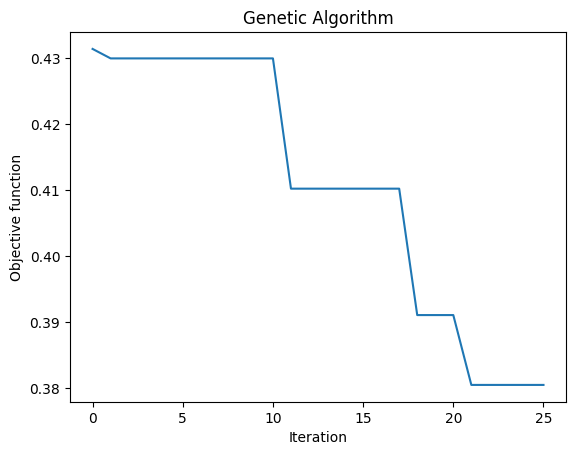

In [6]:
from geneticalgorithm import geneticalgorithm as ga

# Defina os limites usando um array NumPy
varbound = np.array([(0,8), (0,8)])  # Três variáveis com limites de 0 a 10

algorithm_param = {'max_num_iteration': 25,
                   'population_size': 50,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None}

# Função de avaliação do fitness (quanto menor o valor da função, melhor)
def fitness(individual):
    x, y = individual
    return loss([x, y])  

# Agora crie o modelo com variable_boundaries como um array NumPy
model = ga(function=fitness, dimension=2, variable_type='real', variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Execute o algoritmo
model.run()



gen	nevals
0  	50    
1  	36    
2  	32    
3  	21    
4  	40    
5  	27    
6  	23    
7  	38    
8  	26    
9  	24    
10 	34    
11 	26    
12 	31    
13 	28    
14 	24    
15 	37    
16 	34    
17 	40    
18 	24    
19 	33    
20 	35    
21 	24    
22 	24    
23 	36    
24 	31    
25 	24    
26 	29    
27 	30    
28 	33    
29 	27    
30 	34    
31 	37    
32 	35    
33 	30    
34 	27    
35 	27    
36 	33    
37 	30    
38 	22    
39 	34    
40 	30    
Melhor indivíduo: [4.554403032795625, 3.1061896727544536]


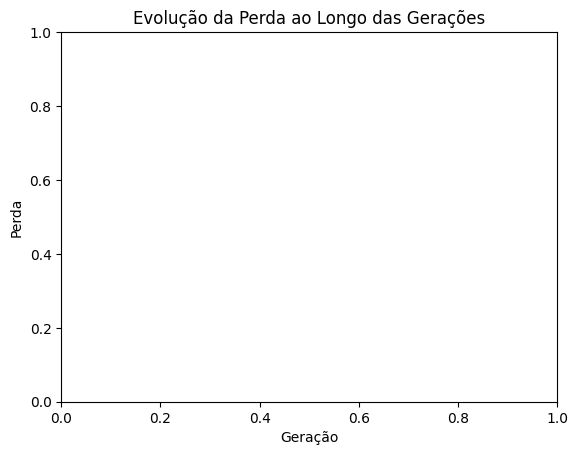

In [8]:
import random
from deap import base, creator, tools, algorithms





def loss(C):
    c1, c2 = C
    h2_sim, h1_sim = simulate(c1, c2)
    total_loss = np.mean(np.square(h1_exp - h1_sim)) + np.mean(
        np.square(h2_exp - h2_sim)
    )

    # print(f"c1: {c1}, c2: {c2}, loss: {total_loss}")
    return (total_loss,)





# Criando os tipos de problemas
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Configurando a população
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -5, 5)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", loss)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Executando o algoritmo
population = toolbox.population(n=50)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=True)


# Encontrando o melhor indivíduo
fits = [ind.fitness.values[0] for ind in population]
best_index = fits.index(min(fits))
print("Melhor indivíduo:", population[best_index])

import matplotlib.pyplot as plt

#plt.plot(losses)
plt.title("Evolução da Perda ao Longo das Gerações")
plt.xlabel("Geração")
plt.ylabel("Perda")
plt.show()



In [14]:
import sys
sys.path.insert(1, '/kaggle/working/cec2017-py')



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import cec2017.functions as functions

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:


def surface_plot_1(function, domain=(-100,100), points=30, dimension=2, ax=None):
    # create points^2 tuples of (x,y) and populate z
    xys = np.linspace(domain[0], domain[1], points)
    xys = np.transpose([np.tile(xys, len(xys)), np.repeat(xys, len(xys))])

    if dimension > 2:
        # concatenate remaining zeros
        tail = np.zeros((xys.shape[0], dimension - 2))
        x = np.concatenate([xys, tail], axis=1)
        zs = function(x)
    else:
        zs = function(xys)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    X = xys[:,0].reshape((points, points))
    Y = xys[:,1].reshape((points, points))
    Z = zs.reshape((points, points))
    surf = ax.plot_surface(X, Y, Z, cmap='plasma') #, edgecolor='none')
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.15, label='')
    ax.set_title(function.__name__)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set the axis color to match the background color
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Set the background color
    ax.set_facecolor((1.0, 1.0, 1.0, 0.0))
    plt.show()
    
    return fig



In [11]:
def contour_plot_1(function, domain=(-100,100), points=30, ax=None, dimension=2):
    # create points^2 tuples of (x,y) and populate z
    xys = np.linspace(domain[0], domain[1], points)
    xys = np.transpose([np.tile(xys, len(xys)), np.repeat(xys, len(xys))])

    if dimension > 2:
        # concatenate remaining zeros
        tail = np.zeros((xys.shape[0], dimension - 2))
        x = np.concatenate([xys, tail], axis=1)
        zs = function(x)
    else:
        zs = function(xys)

    fig = plt.figure()
    ax = fig.gca()

    X = xys[:,0].reshape((points, points))
    Y = xys[:,1].reshape((points, points))
    Z = zs.reshape((points, points))
    cont = ax.contourf(X, Y, Z, lw = 1, levels=20, cmap='plasma')
    ax.contour(X, Y, Z, colors="k", linestyles="solid")
    cbar = fig.colorbar(cont, shrink=0.5, aspect=5, pad=0.15, label='')
#     cbar = fig.colorbar(ax.collections[0], shrink=0.5, aspect=5, pad=0.15, label='')

    ax.set_title(function.__name__)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Set the background color
    ax.set_facecolor((1.0, 1.0, 1.0, 0.0))
    plt.show()
    
    return fig

In [6]:
def surface_plot_2(function, domain=(-100,100), points=30, dimension=2, ax=None):
    # create points^2 tuples of (x,y) and populate z
    xys = np.linspace(domain[0], domain[1], points)
    xys = np.transpose([np.tile(xys, len(xys)), np.repeat(xys, len(xys))])

    if dimension > 2:
        # concatenate remaining zeros
        tail = np.zeros((xys.shape[0], dimension - 2))
        x = np.concatenate([xys, tail], axis=1)
        zs = function(x)
    else:
        zs = function(xys)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    X = xys[:,0].reshape((points, points))
    Y = xys[:,1].reshape((points, points))
    Z = zs.reshape((points, points))

    # plot surface
    surf = ax.plot_surface(X, Y, Z, cmap='plasma') #, edgecolor='none')
    ax.contour(X, Y, Z, zdir='z', cmap="plasma", linestyles="solid", offset=40)
    ax.contour(X, Y, Z, zdir='z', colors="k", linestyles="solid")
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.15, label='')
    ax.set_title(function.__name__)

    # plot contour
    ax.contour(X, Y, Z, levels=10, cmap='plasma')
    
    ax.set_title(function.__name__)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('y')

    # Set the background color
    ax.set_facecolor((1.0, 1.0, 1.0, 0.0))
    plt.show()
    
    return fig

In [9]:


Dim = 100
NP = 10
bound = 100



In [12]:


for f in functions.all_functions:
    surface_plot_2(f, points=120, dimension=Dim)



TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>

In [14]:
# Using only f5:
from cec2017.functions import f5
samples = 3
dimension = 50
x = np.random.uniform(-100, 100, size=(samples, dimension))
val = f5(x)
for i in range(samples):
    print(f"f5(x_{i}) = {val[i]:.6f}")

# Using all functions:
from cec2017.functions import all_functions
for f in all_functions:
    x = np.random.uniform(-100, 100, size=(samples, dimension))
    val = f(x)
    for i in range(samples):
        print(f"{f.__name__}(x_{i}) = {val[i]:.6f}")

f5(x_0) = 2224.533121
f5(x_1) = 1952.909980
f5(x_2) = 2347.534596
f1(x_0) = 3730155609104.289551
f1(x_1) = 2957506395824.063477
f1(x_2) = 4731275133798.346680
f2(x_0) = 152188853588672337532946112091299571264976765796429162285987325802907292727967516354286152216735645696.000000
f2(x_1) = 152201637130020329182663314488946191185384768417417552194462001147654455683996444417932174295040.000000
f2(x_2) = 5322923800219726064706034622833578972892260518033487121190424826531641337452345881320751104.000000
f3(x_0) = 14802573374.365711
f3(x_1) = 2370371301448804.000000
f3(x_2) = 159459831214322.968750
f4(x_0) = 126738.380453
f4(x_1) = 155942.420747
f4(x_2) = 352550.280349
f5(x_0) = 1976.404099
f5(x_1) = 1919.783634
f5(x_2) = 1905.493020
f6(x_0) = 879.698784
f6(x_1) = 928.785919
f6(x_2) = 905.258788
f7(x_0) = 8624.715341
f7(x_1) = 9679.814285
f7(x_2) = 9223.607931
f8(x_0) = 2418.639295
f8(x_1) = 2029.681829
f8(x_2) = 2053.282074
f9(x_0) = 281352.269284
f9(x_1) = 162073.770765
f9(x_2) = 188944.6569